# Integrating the Anisotropic Ginzburg-Landau Equation using Physics-Informed Neural Networks

Este notebook busca ser más que nada un proof of concept. Para correrlo es recomendable crear un entorno virtual (con python -m venv .venv), activarlo con source .venv/bin/activate y luego instalar las dependencias con pip install -r requirements.txt (asumiendo que lo llama desde el mismo directorio). De lo contrario puede que se instalen un montón de cosas en el ambiente global de python que no es lo ideal y podrían haber choques con las versiones.

## La ecuación en sí:

Antes de meterme con la ecuación forzada anisotrópica, veamos si es posible integrar esta ecuación:

$$
\partial_t A = \mu A + \nabla^2 A - A |A|^2
$$

Esta es la ecuación de Ginzburg-Landau compleja de toda la vida.


In [11]:
import torch

In [12]:
# Numpy y matplotlib
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# Librería con la magia pues
import deepxde as dde
torch.set_default_device("cpu")

In [13]:
# Cargamos las condiciones iniciales:
import scipy
# import scipy.io as sio
# UV = sio.loadmat('./uv_2x1602x100x100_Euler_[dt=0.0125,HighOrderLap].mat')['uv']
# U0 = UV[0:1, 100:101, :, :][0, 0, :, :]
# V0 = UV[1:2, 100:101, :, :][0, 0, :, :]

# g0 = np.transpose(UV[0:2, 100:101, :, :][:, 0, :, :], (1, 2, 0))

# domain = 0.2*np.arange(0, 100)
# w_0 = scipy.interpolate.RegularGridInterpolator((domain, domain), U0, method="cubic")
# z_0 = scipy.interpolate.RegularGridInterpolator((domain, domain), V0, method="cubic")
# f_0 = scipy.interpolate.RegularGridInterpolator((domain, domain), g0, method="cubic")

In [14]:
# Creo algunos dominios:

x_lower = -5
x_upper = 5

y_lower = -5
y_upper = 5

t_lower = 0
t_upper = 10.0

# Space and time domains/geometry (for the deepxde model)
space_domain = dde.geometry.Rectangle([x_lower, y_lower], [x_upper, y_upper])
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

# IC creation
ic_w = dde.icbc.IC(geomtime, lambda xt: w_0(xt[:, :2]), lambda _, on_initial: on_initial, component=0)
ic_z = dde.icbc.IC(geomtime, lambda xt: z_0(xt[:, :2]), lambda _, on_initial: on_initial, component=1)

In [15]:
# Definimos nuestra función de pérdida:

def lambda_Omega(xy, u):
    """
    Calcula la desviación de la ecuación de Ginzburg-Landau compleja para una función u en un dominio xy.

    Parámetros:
    - xy: array de tamaño (n, 3) que representa las coordenadas (x, y, t) de los puntos en el dominio.
    - u: array de tamaño (n, 2) que representa los valores de la parte real e imaginaria de la función u en el dominio.

    Retorna:
    - Array de tamaño (n, 1), que da cuenta de la desviación de cumplir la ecuación de Ginzburg-Landau en cada punto de xy.
    """
    
    # constantes:
    mu = 0.1
    beta = 1.0
    
    w = u[:, 0:1]
    z = u[:, 1:2]
    
    # Derivadas de u
    w_t = dde.grad.jacobian(u, xy, i=0, j=2)
    z_t = dde.grad.jacobian(u, xy, i=1, j=2) # El índice i para esta fun es el índice del input al que se le calcula el gradiente. El índice j indica la componente del gradiente.
    
    w_xx = dde.grad.hessian(u, xy, component=0, i=0, j=0)
    z_xx = dde.grad.hessian(u, xy, component=1, i=0, j=0)
    w_yy = dde.grad.hessian(u, xy, component=0, i=1, j=1)
    z_yy = dde.grad.hessian(u, xy, component=1, i=1, j=1)

    w_error = mu * (w_xx + w_yy) + (1 - w**2 - z**2) * w + beta * z * (w**2 + z**2) - w_t# fijo mu = 1 porque no sé pasarle parámetros a la función de pérdida todavía y lo otro puede ser computacionalmente costoso.
    z_error = mu * (z_xx + z_yy) - beta * (w**2 + z**2) * w + (1 - w**2 - z**2) * z
    return [w_error, z_error]

In [16]:
# Condiciones Iniciales y de borde mediante transform:

def transform(xyt, pretransform_out):
    return torch.cos(2*torch.pi*torch.sqrt(xyt[:, 0:1]**2 + xyt[:, 1:2]**2) + 2*torch.arctan2(xyt[:, 1:2], xyt[:, 0:1])) + xyt[:, 2:3] * pretransform_out # esto me asegura que la condición inicial se cumpla.


In [17]:
data = dde.data.TimePDE(
    geomtime,
    lambda_Omega,
    #[ic_w, ic_z],
    [],
    num_domain=100,
    num_boundary=1,
    num_initial=1,
    train_distribution="pseudo",
)


# Network architecture
net = dde.nn.FNN([3] + [80] * 4 + [2], "tanh", "Glorot normal")

net.apply_output_transform(transform)

model = dde.Model(data, net)

In [18]:
# Es recomendado utilizar aceleración con GPU, es más fácil si es una GPU de NVIDIA lamentablemente.
model.compile("adam", lr=1e-3, loss="MSE")
model.train(iterations=5_000, display_every=100)

Compiling model...
'compile' took 0.000250 s

Training model...

0         [7.97e+03, 1.68e+04]    [7.97e+03, 1.68e+04]    []  
100       [5.02e+00, 1.94e+01]    [5.02e+00, 1.94e+01]    []  
200       [5.03e+00, 1.81e+01]    [5.03e+00, 1.81e+01]    []  
300       [5.03e+00, 1.75e+01]    [5.03e+00, 1.75e+01]    []  
400       [5.04e+00, 1.71e+01]    [5.04e+00, 1.71e+01]    []  
500       [5.04e+00, 1.68e+01]    [5.04e+00, 1.68e+01]    []  
600       [5.05e+00, 1.66e+01]    [5.05e+00, 1.66e+01]    []  
700       [5.05e+00, 1.64e+01]    [5.05e+00, 1.64e+01]    []  
800       [5.05e+00, 1.62e+01]    [5.05e+00, 1.62e+01]    []  


KeyboardInterrupt: 

In [ ]:
# Further optim with L-BFGS-B
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.000368 s

Training model...

Step      Train loss              Test loss               Test metric
5000      [4.67e+00, 1.37e+01]    [4.67e+00, 1.37e+01]    []  

Best model at step 5000:
  train loss: 1.84e+01
  test loss: 1.84e+01
  test metric: []

'train' took 0.007614 s



### La red ya fue entrenada, ahora veamos si lo que tira tiene sentido:

In [ ]:
# Creation of the 2D domain (for plotting and input)
# plt.close("all")
# time_to_plot = 7.0  # forma burda de seleccionar el tiempo a plotear.

# x = np.linspace(x_lower, x_upper, 256)
# y = np.linspace(y_lower, y_upper, 256)
# t = np.array([time_to_plot])

# X, Y, T = np.meshgrid(x, y, t)

# X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))
# X_doublestar = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

# # Predecimos:
# prediction = model.predict(X_star, operator=None)
# print(prediction.shape)

# # Reshape the prediction to match the grid shape
# U_pred = prediction[:, 0].reshape(X.shape[:2])
# V_pred = prediction[:, 1].reshape(X.shape[:2])

# # Plotting
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# ax[0].imshow(
#     U_pred,
#     interpolation="nearest",
#     cmap="viridis",
#     extent=[x_lower, x_upper, y_lower, y_upper],
#     origin="lower",
#     aspect="auto",
# )
# ax[0].set_title("u(x, y)")

# ax[1].imshow(
#     V_pred,
#     interpolation="nearest",
#     cmap="viridis",
#     extent=[x_lower, x_upper, y_lower, y_upper],
#     origin="lower",
#     aspect="auto",
# )
# ax[1].set_title("v(x, y)")

# plt.show()

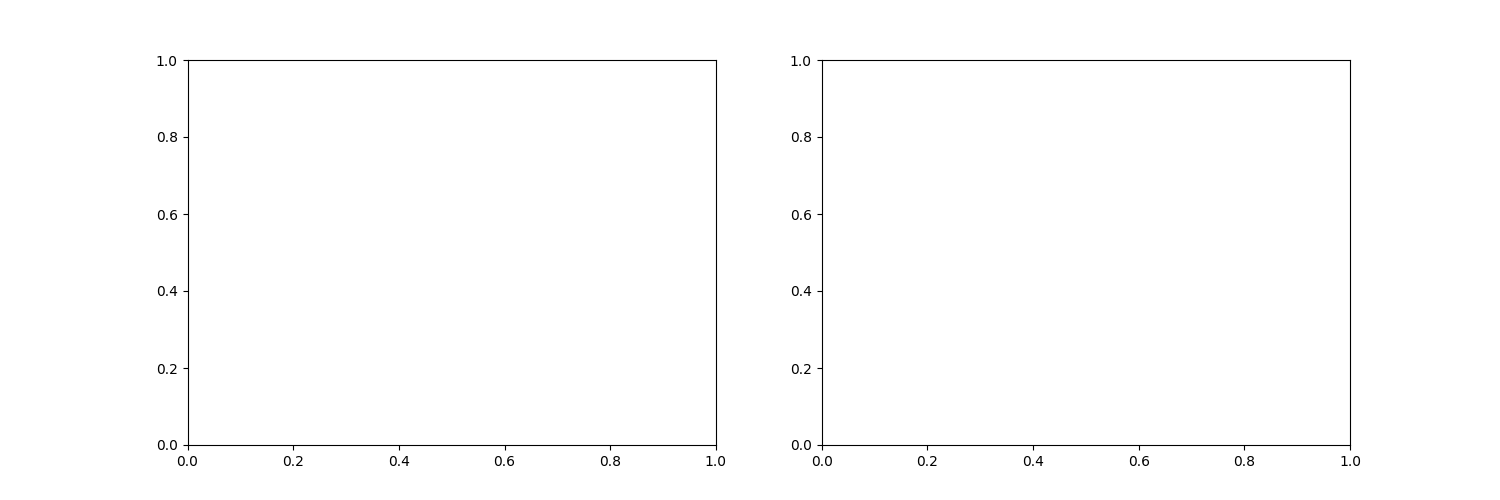

In [ ]:
# Lo mismo pero con animación:
plt.close()
from matplotlib.animation import FuncAnimation

x = np.linspace(x_lower, x_upper, 128)
y = np.linspace(y_lower, y_upper, 128)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

def animate(t):
    t = np.array([t])
    X, Y, T = np.meshgrid(x, y, t)

    X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))
    prediction = model.predict(X_star, operator=None)
    U_pred = prediction[:, 0].reshape(X.shape[:2])
    V_pred = prediction[:, 1].reshape(X.shape[:2])
    ax[0].clear()
    ax[1].clear()
    ax[0].imshow(
        U_pred,
        interpolation="nearest",
        cmap="viridis",
        extent=[x_lower, x_upper, y_lower, y_upper],
        origin="lower",
        aspect="auto",
    )
    ax[0].set_title("u(x, y) at t={:.2f}".format(t[0]))
    ax[1].imshow(
        V_pred,
        interpolation="nearest",
        cmap="viridis",
        extent=[x_lower, x_upper, y_lower, y_upper],
        origin="lower",
        aspect="auto",
    )
    ax[1].set_title("v(x, y) at t={:.2f}".format(t[0]))
    return ax,

ani = FuncAnimation(fig, animate, frames=np.linspace(0, 10, 101), blit=False, repeat=True)
